<a href="https://colab.research.google.com/github/ErmekZhumagulov/prices-prognosis/blob/main/Prices_prognosis_eur_usd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Нейронные сети прогноза закрытия следующей свечи.

Импорт необходимых библиотек:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
import math

Импорт данных и переименование названия столбцов:

In [3]:
filename = files.upload()
df = pd.read_csv(io.BytesIO(filename['EURUSD_220117_230117.csv']), sep=',')
print(df.shape, df.columns)
df.rename(columns={'<DATE>': 'Date', '<TIME>': 'Time', '<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', '<CLOSE>': 'Close', '<VOL>': 'Volume'}, inplace=True)
print(df.shape, df.columns)

Saving EURUSD_220117_230117.csv to EURUSD_220117_230117 (1).csv
(6425, 7) Index(['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>'], dtype='object')
(6425, 7) Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


Обьединение даты и времени в один столбец:

In [4]:
df["DateTime"] = df['Date'] + " " + df["Time"]

Преобразование столбца даты с временем из str в datetime:

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M:%S')
print(df.shape, df.columns)

(6425, 8) Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'DateTime'], dtype='object')


Просмотр полученных данных:

In [6]:
df

,Date,Time,Open,High,Low,Close,Volume,DateTime
0,17/01/22,02:00:00,1.14128,1.14169,1.14119,1.14151,6360,2022-01-17 02:00:00
1,17/01/22,03:00:00,1.14150,1.14159,1.14040,1.14110,30214,2022-01-17 03:00:00
2,17/01/22,04:00:00,1.14105,1.14118,1.14020,1.14076,29191,2022-01-17 04:00:00
3,17/01/22,05:00:00,1.14072,1.14087,1.13980,1.14043,36932,2022-01-17 05:00:00
4,17/01/22,06:00:00,1.14047,1.14178,1.14020,1.14155,28470,2022-01-17 06:00:00
...,...,...,...,...,...,...,...,...
6420,17/01/23,15:00:00,1.08214,1.08338,1.08120,1.08316,111955,2023-01-17 15:00:00
6421,17/01/23,16:00:00,1.08322,1.08577,1.08210,1.08523,142646,2023-01-17 16:00:00
6422,17/01/23,17:00:00,1.08528,1.08580,1.08350,1.08424,187522,2023-01-17 17:00:00
6423,17/01/23,18:00:00,1.08423,1.08699,1.08410,1.08627,203055,2023-01-17 18:00:00


Убираем несформулившуюся свечу(последнюю):

In [7]:
df = df.drop(df.index[len(df)-1])
df

,Date,Time,Open,High,Low,Close,Volume,DateTime
0,17/01/22,02:00:00,1.14128,1.14169,1.14119,1.14151,6360,2022-01-17 02:00:00
1,17/01/22,03:00:00,1.14150,1.14159,1.14040,1.14110,30214,2022-01-17 03:00:00
2,17/01/22,04:00:00,1.14105,1.14118,1.14020,1.14076,29191,2022-01-17 04:00:00
3,17/01/22,05:00:00,1.14072,1.14087,1.13980,1.14043,36932,2022-01-17 05:00:00
4,17/01/22,06:00:00,1.14047,1.14178,1.14020,1.14155,28470,2022-01-17 06:00:00
...,...,...,...,...,...,...,...,...
6419,17/01/23,14:00:00,1.08172,1.08275,1.08080,1.08208,127928,2023-01-17 14:00:00
6420,17/01/23,15:00:00,1.08214,1.08338,1.08120,1.08316,111955,2023-01-17 15:00:00
6421,17/01/23,16:00:00,1.08322,1.08577,1.08210,1.08523,142646,2023-01-17 16:00:00
6422,17/01/23,17:00:00,1.08528,1.08580,1.08350,1.08424,187522,2023-01-17 17:00:00


Делим данные на train и test:

In [8]:
split = 0.85
i_split = int(len(df) * split)
cols = ['Close', 'Volume']
data_train = df.get(cols).values[:i_split]
data_test = df.get(cols).values[i_split:]
len_train = len(data_train)
len_test = len(data_test)
print(len(df), len_train, len_test)

6424 5460 964


In [9]:
len_train, data_train, len_test, data_test

(5460, array([[1.14151e+00, 6.36000e+03],
        [1.14110e+00, 3.02140e+04],
        [1.14076e+00, 2.91910e+04],
        ...,
        [1.03114e+00, 1.05722e+05],
        [1.03194e+00, 8.74600e+04],
        [1.03229e+00, 1.02190e+05]]), 964, array([[1.03319e+00, 2.02854e+05],
        [1.03673e+00, 2.30916e+05],
        [1.03760e+00, 2.61644e+05],
        ...,
        [1.08523e+00, 1.42646e+05],
        [1.08424e+00, 1.87522e+05],
        [1.08627e+00, 2.03055e+05]]))

In [10]:
data_train.shape, data_test.shape

((5460, 2), (964, 2))

Начинаем формировать нашу нейронку:

In [11]:
sequence_length = 50
input_dim = 2
batch_size = 32
epochs = 2

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(sequence_length-1, input_dim), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 49, 100)           41200     
                                                                 
 dropout (Dropout)           (None, 49, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 49, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 202,101
Trainable params: 202,101
Non-trai

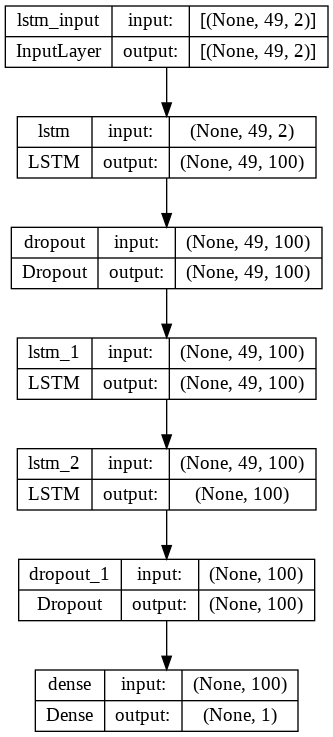

In [14]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Нормализация данных:

In [16]:
def normalise_windows(window_data, single_window=False):
  normalised_data = []
  window_data = [window_data] if single_window else window_data
  for window in window_data:
    normalised_window = []
    for col_i in range(window.shape[1]):
      normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
      normalised_window.append(normalised_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
  return np.array(normalised_data)

In [17]:
def _next_window(i, seq_len, normalise):
  window = data_train[i:i+seq_len]
  window = normalise_windows(window, single_window=True)[0] if normalise else window
  x = window[:-1]
  y = window[-1, [0]]
  return x, y

In [18]:
def get_train_data(seq_len, normalise):
  data_x = []
  data_y = []
  for i in range(len_train - seq_len + 1):
    x, y = _next_window(i, seq_len, normalise)
    data_x.append(x)
    data_y.append(y)
  return np.array(data_x), np.array(data_y)

In [23]:
x, y = get_train_data(
    seq_len = sequence_length,
    normalise = True
)

In [24]:
print(x, y, x.shape, y.shape)

[[[ 0.00000000e+00  0.00000000e+00]
  [-3.59173376e-04  3.75062893e+00]
  [-6.57024468e-04  3.58977987e+00]
  ...
  [-8.59388004e-03  6.65581761e+00]
  [-8.06826046e-03  2.91305031e+00]
  [-7.72660774e-03  1.18490566e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-2.97958111e-04 -3.38584762e-02]
  [-5.87152747e-04  2.22347256e-01]
  ...
  [-7.71185698e-03 -1.76308996e-01]
  [-7.37008150e-03 -5.40080757e-01]
  [-7.21233897e-03 -4.28609254e-01]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-2.89280830e-04  2.65184475e-01]
  [ 6.92520776e-04 -2.46993936e-02]
  ...
  [-7.07423121e-03 -5.23962865e-01]
  [-6.91644167e-03 -4.08584838e-01]
  [-6.88137733e-03  3.03107122e-01]]

 ...

 [[ 0.00000000e+00  0.00000000e+00]
  [ 1.31032122e-03 -1.74105173e-01]
  [ 7.52945778e-04 -3.24617613e-01]
  ...
  [ 1.13919718e-02 -2.69563758e-01]
  [ 8.43885982e-03 -1.87884174e-02]
  [ 9.62206033e-03 -1.44769635e-01]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-5.56646061e-04 -1.82241654e-01]
  [-3.90628815e-05 -2.2816

In [25]:
import math

steps_per_epoch = math.ceil((len_train - sequence_length) / batch_size)
print(steps_per_epoch)

170


In [26]:
batch_size = 32

In [27]:
from keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='accuracy', patience=2)
]

In [28]:
model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/2
170/170 [==============================] - 30s 135ms/step - loss: 6.6594e-04 - accuracy: 5.5443e-04
Epoch 2/2
170/170 [==============================] - 23s 135ms/step - loss: 1.2238e-04 - accuracy: 5.5443e-04


In [29]:
def get_test_data(seq_len, normalise):
  data_windows = []
  for i in range(len_test - seq_len):
    data_windows.append(data_test[i:i+seq_len])

  data_windows = np.array(data_windows).astype(float)
  data_windows = normalise_windows(data_windows, single_window=False) if normalise else data_windows

  x = data_windows[:, :-1]
  y = data_windows[:, -1, [0]]
  return x, y

In [30]:
x_test, y_test = get_test_data(
    seq_len = sequence_length,
    normalise = True
)

In [32]:
print('test data shapes: ', x_test.shape, y_test.shape)

test data shapes:  (914, 49, 2) (914, 1)


In [33]:
model.evaluate(x_test, y_test, verbose=2)

29/29 - 3s - loss: 4.4871e-05 - accuracy: 0.0011 - 3s/epoch - 100ms/step


[4.4870608689961955e-05, 0.0010940919164568186]